# Project 5

## Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

## Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


## Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

Plan: 
1 - Data preparation
2 - Exploratory Data Analysis 
3 - Feature engineering
4 - Model selection
5 - Decision making
<!-- Data Preparation:

Combine all the different sheets into a single dataset.
Check for any missing or null values and handle them appropriately.
Convert the date column to a datetime format for easy manipulation.
Extract the day, week, and month from the date column for daily, weekly, and monthly predictions.

Exploratory Data Analysis (EDA):

Conduct a comprehensive EDA to identify patterns, trends, and outliers in the data.
Use visualizations such as line plots, scatter plots, histograms, and box plots to explore the data.
Calculate basic statistics such as mean, median, standard deviation, and correlation to gain insights into the data.

Feature Engineering:

Create new features such as moving averages, exponential moving averages, and Bollinger Bands to help capture trends and patterns in the data.
Use technical indicators such as Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Stochastic Oscillator to create additional features.

Model Selection:

Select appropriate models such as Linear Regression, Random Forest Regression, and Support Vector Regression (SVR) to predict the stock prices.
Train the models using the 2020 data and test them on the 2021 Q1 data.
Use evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared to evaluate the performance of the models.

Decision Making:

Use the predicted stock prices to make BUY, HOLD, or SELL decisions.
Calculate the capital returns based on the decisions made.
Use Bollinger Bands to measure the effectiveness of the system.
Minimize the HOLD period by adjusting the decision-making criteria based on the performance of the system -->

In [1]:
#!pip install statsmodels --upgrade
#!pip install TA-Lib
#!pip install fbprophet
#!pip install pmdarima

In [193]:
# linear algebra
import numpy as np 
import random
import math

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

import re
from pylab import rcParams
import statsmodels.api as sm

import talib as ta

import itertools

# Algorithms

from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# #Cross validation
# from sklearn.model_selection import KFold, cross_val_score

# #Other
# from sklearn import metrics
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# #class imbalance
# from sklearn.metrics import f1_score
# from sklearn.utils import resample


# 1 - Data preparation

In [3]:
def clean_sheets(og_data, num):
    def remove_letters(val):
        if isinstance(val, str):
            num = re.findall(r"\d+\.?\d*", val)
            if len(num) > 0:
                num = float(num[0])
                if "K" in val:
                    num /= 1000
                elif "M" in val:
                    num *= 1
                return num
        return val
    data = og_data.parse(num)
    # remove the last row as it contains text
    data.drop([data.shape[0]-1], axis=0, inplace=True)
    #clean up date column
    data[["Date"]] = data[["Date"]].apply(pd.to_datetime)
    #clean up Vol column
    data['Vol.'] = data['Vol.'].apply(remove_letters)
    #make columns numeric
    data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]] = data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]].apply(pd.to_numeric)
    # Set the 'Date' column as the index
    data.set_index('Date', inplace=True)
    # make the Date values the index
    data = data.sort_values(by=['Date'], ascending=True)
    print(data.head())
        # Check data types of columns
    print(data.dtypes)

    # Check for missing values
    print(data.isnull().sum())
    return data

In [4]:
og_data = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [5]:
data1 = clean_sheets(og_data, 1)

            Price   Open   High    Low  Vol.  Change %
Date                                                  
2020-01-02  20.38  20.42  20.44  20.24  2.53    0.0030
2020-01-03  20.30  20.30  20.44  19.97  3.31   -0.0039
2020-01-06  20.08  20.34  20.34  19.97  1.94   -0.0108
2020-01-07  19.93  20.22  20.28  19.92  2.89   -0.0075
2020-01-08  19.94  19.89  19.95  19.66  2.79    0.0005
Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [6]:
data1['Price']

Date
2020-01-02    20.38
2020-01-03    20.30
2020-01-06    20.08
2020-01-07    19.93
2020-01-08    19.94
              ...  
2021-03-25    20.02
2021-03-26    19.25
2021-03-29    19.10
2021-03-30    19.50
2021-03-31    19.41
Name: Price, Length: 315, dtype: float64

In [7]:
data1.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-02,20.38,20.42,20.44,20.24,2.53,0.0030
2020-01-03,20.30,20.30,20.44,19.97,3.31,-0.0039
2020-01-06,20.08,20.34,20.34,19.97,1.94,-0.0108
2020-01-07,19.93,20.22,20.28,19.92,2.89,-0.0075
2020-01-08,19.94,19.89,19.95,19.66,2.79,0.0005


In [8]:
data1.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046


# 2 - Exploratory Data Analysis 

In [9]:
def exploration(df):
    
    # Summary statistics of the data
    print(df.describe())
        # Visualize data distribution of numeric columns
    df.hist(bins=10, figsize=(15, 10))
    plt.show()

    # Visualize correlation between variables
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.show()

    # Explore relationships between variables using scatter plots
    sns.pairplot(df, x_vars=['Price', 'Vol.'], y_vars=['Change %'], size=5, aspect=0.8, kind='scatter')
    plt.show()

            Price        Open        High         Low        Vol.    Change %
count  315.000000  315.000000  315.000000  315.000000  315.000000  315.000000
mean    17.857397   17.879397   18.146286   17.608667   11.087810    0.000149
std      2.891400    2.877779    2.944378    2.850359    8.029082    0.024198
min     12.790000   12.970000   13.110000   12.380000    1.920000   -0.099400
25%     15.010000   15.080000   15.225000   14.840000    5.685000   -0.013350
50%     17.580000   17.640000   17.860000   17.450000    8.720000    0.000700
75%     20.130000   20.190000   20.360000   19.970000   13.830000    0.014950
max     24.080000   24.380000   25.480000   23.480000   56.570000    0.078000


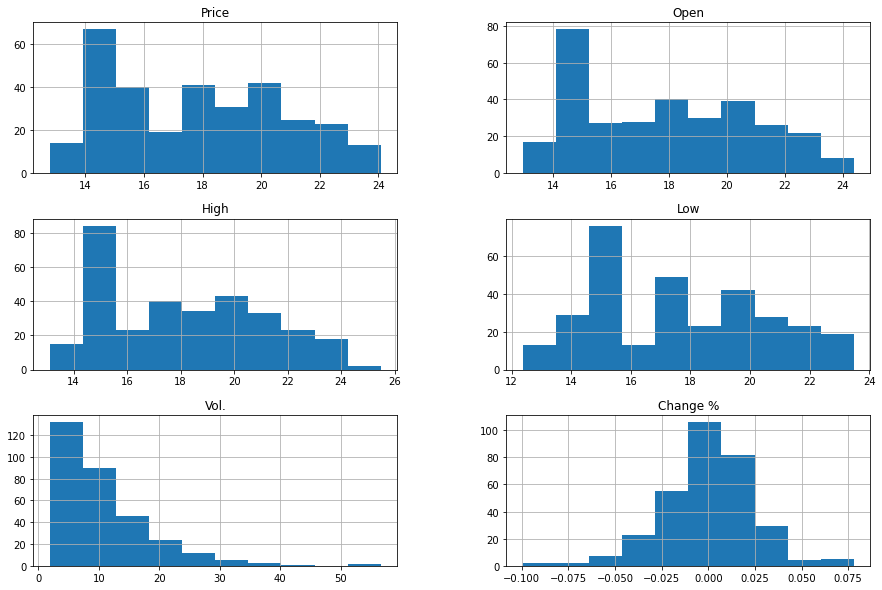

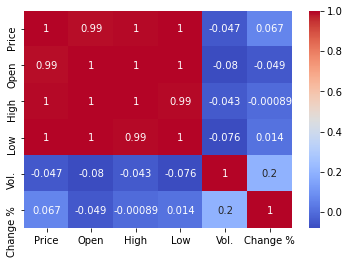

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


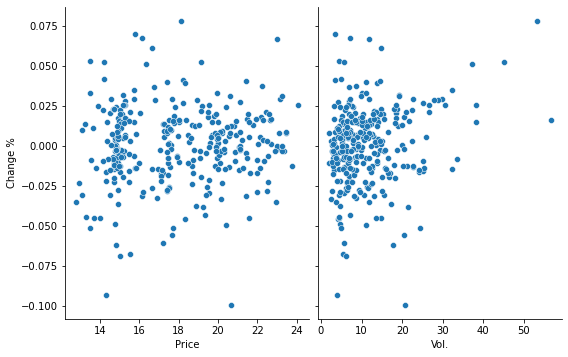

In [10]:
exploration(data1)

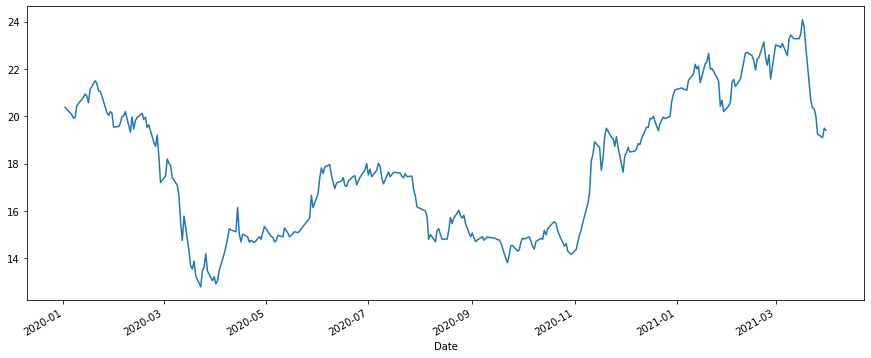

In [11]:
y = data1['Price'][:]
y.plot(figsize=(15, 6))
plt.show()

In [12]:
print(y)

Date
2020-01-02    20.38
2020-01-03    20.30
2020-01-06    20.08
2020-01-07    19.93
2020-01-08    19.94
              ...  
2021-03-25    20.02
2021-03-26    19.25
2021-03-29    19.10
2021-03-30    19.50
2021-03-31    19.41
Name: Price, Length: 315, dtype: float64


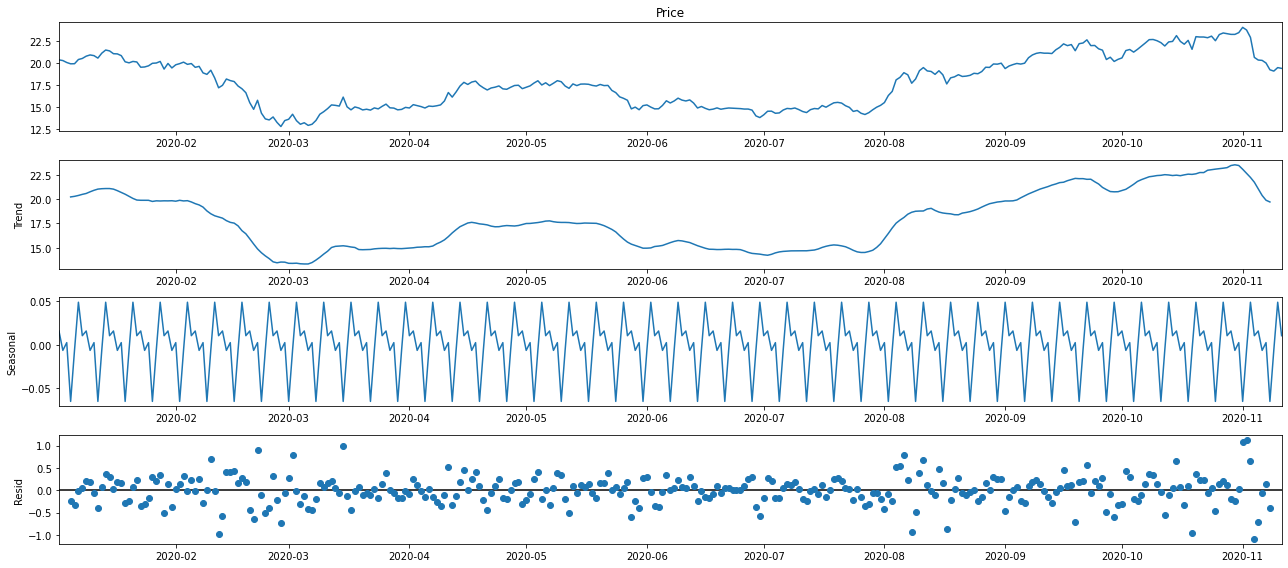

In [13]:
y.index = pd.date_range(start='2020-01-02', periods=len(y), freq='D')

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# 3 - Feature engineering: making weekly, monthly

In [14]:
# Resample the data on a weekly basis
data1W = data1.resample('W').last()
# Resample the data on a monthly basis 
data1M = data1.resample('M').last()

In [15]:
print(data1W)

            Price   Open   High    Low   Vol.  Change %
Date                                                   
2020-01-05  20.30  20.30  20.44  19.97   3.31   -0.0039
2020-01-12  20.54  20.54  20.70  20.26   4.38    0.0059
2020-01-19  21.14  20.60  21.14  20.40   4.18    0.0272
2020-01-26  20.86  21.26  21.28  20.62   3.49   -0.0095
2020-02-02  19.54  20.12  20.12  19.54   5.75   -0.0298
...           ...    ...    ...    ...    ...       ...
2021-03-07  23.08  22.82  23.32  22.78   6.74    0.0079
2021-03-14  23.28  23.30  23.44  23.06   5.04   -0.0034
2021-03-21  22.94  23.76  23.78  22.92  11.89   -0.0353
2021-03-28  19.25  20.28  20.36  19.10  21.35   -0.0385
2021-04-04  19.41  19.42  19.63  19.27  13.14   -0.0046

[66 rows x 6 columns]


In [16]:
data1M

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-31,19.54,20.12,20.12,19.54,5.75,-0.0298
2020-02-29,17.20,18.10,18.30,16.78,5.72,-0.0611
2020-03-31,13.22,13.14,13.42,13.06,5.64,0.0136
2020-04-30,15.34,15.20,15.55,15.10,13.68,0.0166
2020-05-31,16.14,16.58,17.00,16.14,13.14,-0.0312
2020-06-30,18.00,17.76,18.17,17.64,14.13,0.0147
2020-07-31,16.17,16.65,16.68,16.17,4.60,-0.0288
2020-08-31,14.90,15.45,15.46,14.90,17.25,-0.0362
2020-09-30,14.67,14.45,14.71,14.38,18.72,0.0230


# 4 - Models

In [17]:
data1.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [18]:
data1.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046


In [19]:
print(data1.iloc[-64])
print(64/len(data1))

Price       21.1200
Open        20.8400
High        21.3800
Low         20.7200
Vol.         7.1200
Change %     0.0086
Name: 2020-12-31 00:00:00, dtype: float64
0.20317460317460317


In [20]:
# mean_absolute_error(y_true, y_pred)

## LSTM models

In [309]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:i+look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def pre_LSTM(df):
    data = df['Price']
    data = data.values
    data = data.astype('float32')
    data = data.reshape(-1, 1)
    return data

def model_LSTM(dataset, look_back=1, epochs = 5, model_type = False):
    
    train = pre_LSTM(dataset[dataset.index < '2021-01-01'])
    testY = pre_LSTM(dataset[dataset.index >= '2021-01-01'])
    
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    
    # # create and fit the LSTM network

    tf.random.set_seed(41)

    model = Sequential()
    if not model_type:
        model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))        
    elif model_type == 'seq':
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(50, activation='relu'))
    elif model_type =='bi':
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(look_back, 1)))
    model.add(Dense(1))        
    model.compile(optimizer='adam', loss='mse')
    model.fit(trainX, trainY, epochs=epochs, verbose=0)
    

    # make predictions

    # Prepare input data
    inputs = trainX[-1:]
    inputs = np.append(inputs[:,1:,:], [[[trainY[-1]]]], axis=1)

    # Predict next values
    forecasts = []
    for i in range(len(testY)):
        # Forecast next value
        forecast = model.predict(inputs, verbose = 0)
        forecast = forecast[-1][-1].round(2)
        forecasts.append(forecast)
        new = np.append(inputs[:,1:,:],[[[forecast]]],axis=1)
        # Update input sequence
        inputs = new
    
    # Print forecasts
    print(f"Next {len(forecasts)} values: ", forecasts)   
    testScore = np.sqrt(mean_squared_error(testY, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))

    
    #make dataframe for results
    df_forecast = pd.DataFrame(forecasts,columns=['Prediction'])
    df_forecast.index = dataset[dataset.index >= '2021-01-01'].index
    
    forecasts = np.array(forecasts)
    forecasts = forecasts.reshape(-1, 1)
    
    dataset = pre_LSTM(dataset)
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[-len(testY):, :] = forecasts
    
    # plot baseline and predictions
    plt.plot(dataset, color = 'b')
    plt.plot(testPredictPlot, color = 'r')
    plt.show()
    
    return df_forecast

### Daily basis

Next 63 values:  [21.28, 21.46, 21.57, 21.7, 21.82, 21.94, 22.06, 22.18, 22.31, 22.44, 22.57, 22.71, 22.85, 22.99, 23.14, 23.29, 23.45, 23.61, 23.78, 23.96, 24.14, 24.33, 24.52, 24.72, 24.92, 25.11, 25.29, 25.47, 25.64, 25.81, 25.97, 26.13, 26.28, 26.43, 26.57, 26.71, 26.84, 26.97, 27.09, 27.21, 27.32, 27.43, 27.53, 27.63, 27.73, 27.82, 27.91, 28.0, 28.08, 28.16, 28.24, 28.31, 28.38, 28.45, 28.51, 28.57, 28.63, 28.69, 28.74, 28.79, 28.84, 28.89, 28.94]
Test Score: 4.58 RMSE


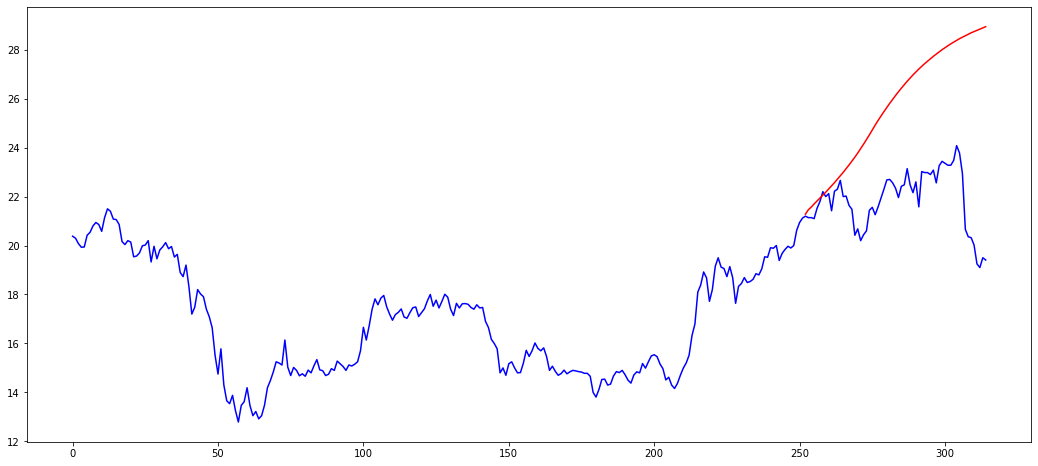

,Prediction
Date,
2021-01-04,21.280001
2021-01-05,21.459999
2021-01-06,21.570000
2021-01-07,21.700001
2021-01-08,21.820000
...,...
2021-03-25,28.740000
2021-03-26,28.790001
2021-03-29,28.840000


In [172]:
model_LSTM(data1, 5, 200)

Next 63 values:  [21.1, 21.07, 20.95, 20.8, 20.63, 20.45, 20.27, 20.08, 19.9, 19.72, 19.54, 19.36, 19.19, 19.02, 18.85, 18.68, 18.52, 18.36, 18.2, 18.04, 17.89, 17.74, 17.59, 17.45, 17.31, 17.17, 17.03, 16.9, 16.77, 16.64, 16.51, 16.39, 16.27, 16.16, 16.05, 15.95, 15.85, 15.75, 15.66, 15.57, 15.49, 15.41, 15.34, 15.28, 15.23, 15.18, 15.14, 15.1, 15.07, 15.04, 15.01, 14.99, 14.97, 14.95, 14.93, 14.91, 14.89, 14.88, 14.87, 14.86, 14.85, 14.84, 14.83]
Test Score: 5.48 RMSE


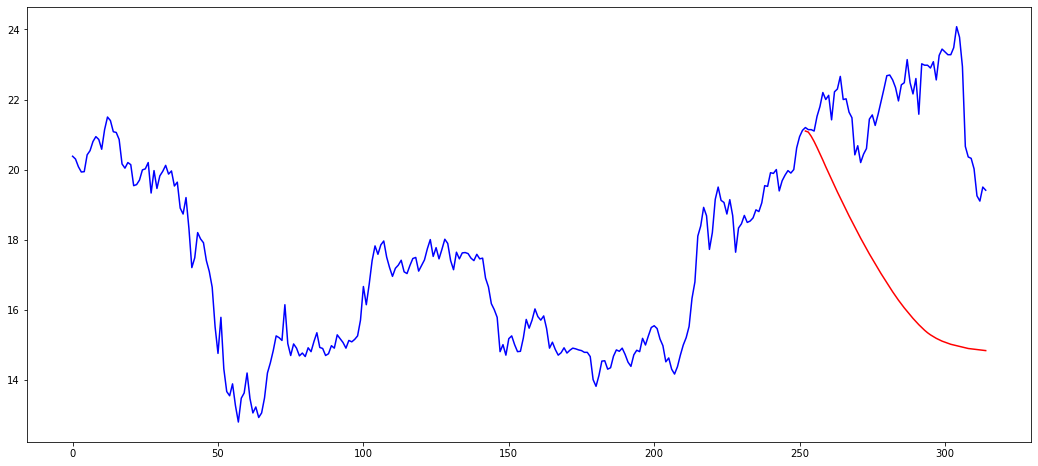

,Prediction
Date,
2021-01-04,21.100000
2021-01-05,21.070000
2021-01-06,20.950001
2021-01-07,20.799999
2021-01-08,20.629999
...,...
2021-03-25,14.870000
2021-03-26,14.860000
2021-03-29,14.850000


In [180]:
model_LSTM(data1, 5, 200, model_type ='seq')

Next 63 values:  [20.95, 20.91, 20.78, 20.61, 20.43, 20.29, 20.13, 19.99, 19.86, 19.75, 19.64, 19.55, 19.47, 19.39, 19.32, 19.26, 19.2, 19.15, 19.1, 19.06, 19.02, 18.98, 18.95, 18.92, 18.89, 18.86, 18.83, 18.81, 18.78, 18.76, 18.74, 18.72, 18.7, 18.68, 18.66, 18.65, 18.63, 18.62, 18.61, 18.6, 18.59, 18.58, 18.57, 18.56, 18.55, 18.54, 18.53, 18.52, 18.51, 18.5, 18.49, 18.48, 18.47, 18.47, 18.46, 18.46, 18.45, 18.45, 18.44, 18.44, 18.44, 18.43, 18.43]
Test Score: 3.21 RMSE


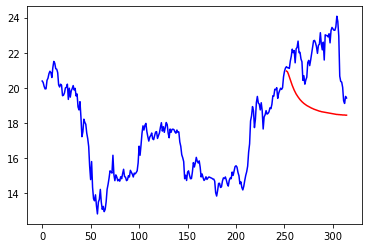

,Prediction
Date,
2021-01-04,20.950001
2021-01-05,20.910000
2021-01-06,20.780001
2021-01-07,20.610001
2021-01-08,20.430000
...,...
2021-03-25,18.440001
2021-03-26,18.440001
2021-03-29,18.440001


In [183]:
model_LSTM(data1, 5, 200, model_type ='bi')

Next 63 values:  [20.98, 20.95, 20.94, 20.91, 20.85, 20.76, 20.67, 20.59, 20.51, 20.42, 20.33, 20.23, 20.13, 20.03, 19.92, 19.8, 19.67, 19.54, 19.4, 19.25, 19.09, 18.92, 18.74, 18.55, 18.35, 18.14, 17.92, 17.68, 17.43, 17.17, 16.9, 16.62, 16.33, 16.04, 15.75, 15.46, 15.18, 14.91, 14.66, 14.44, 14.25, 14.09, 13.97, 13.89, 13.84, 13.82, 13.83, 13.86, 13.91, 13.97, 14.03, 14.1, 14.17, 14.24, 14.31, 14.37, 14.43, 14.48, 14.53, 14.57, 14.6, 14.62, 14.64]
Test Score: 5.83 RMSE


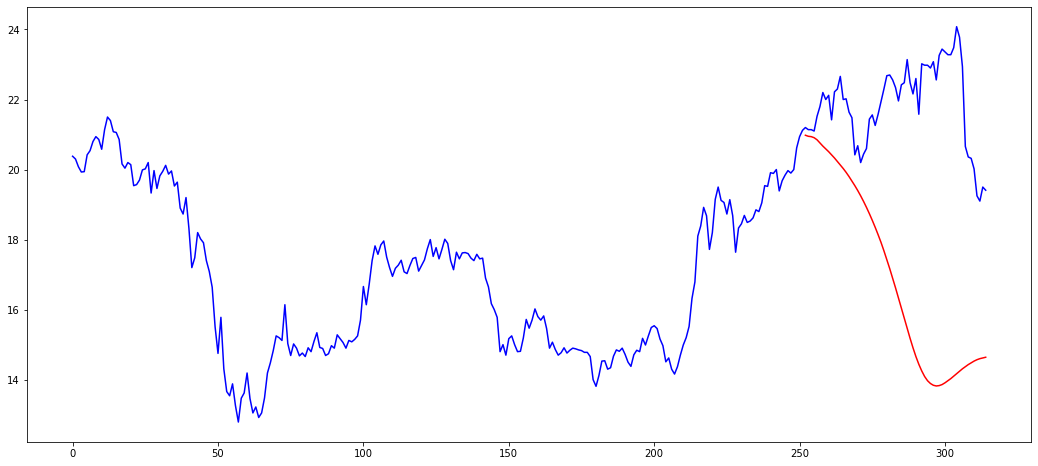

,Prediction
Date,
2021-01-04,20.980000
2021-01-05,20.950001
2021-01-06,20.940001
2021-01-07,20.910000
2021-01-08,20.850000
...,...
2021-03-25,14.530000
2021-03-26,14.570000
2021-03-29,14.600000


In [174]:
model_LSTM(data1, 10, 200)

Next 63 values:  [21.02, 21.04, 21.1, 21.13, 21.09, 21.0, 20.92, 20.85, 20.77, 20.68, 20.58, 20.48, 20.39, 20.3, 20.21, 20.12, 20.03, 19.95, 19.87, 19.8, 19.73, 19.66, 19.6, 19.54, 19.49, 19.44, 19.39, 19.34, 19.29, 19.25, 19.21, 19.17, 19.13, 19.09, 19.05, 19.01, 18.97, 18.93, 18.89, 18.85, 18.81, 18.77, 18.73, 18.69, 18.65, 18.61, 18.57, 18.53, 18.49, 18.45, 18.41, 18.37, 18.33, 18.29, 18.25, 18.21, 18.17, 18.13, 18.08, 18.03, 17.98, 17.93, 17.88]
Test Score: 2.98 RMSE


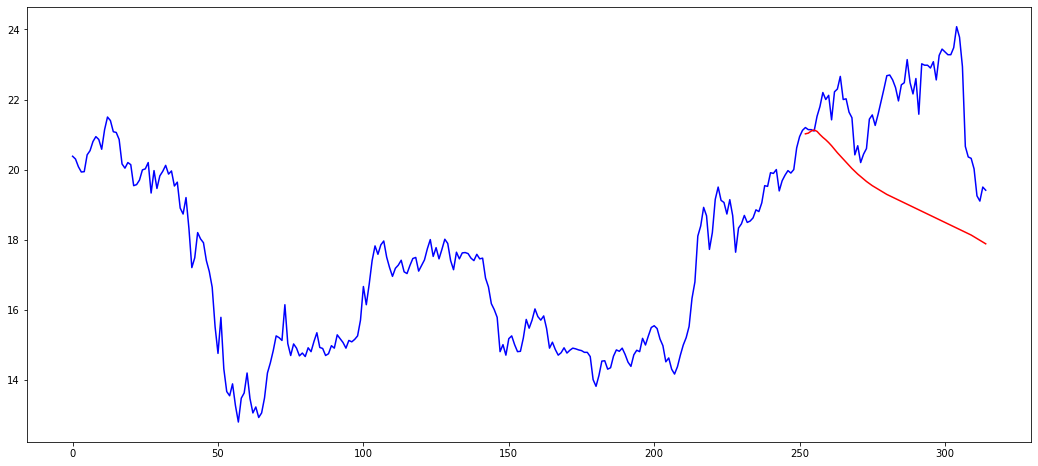

,Prediction
Date,
2021-01-04,21.020000
2021-01-05,21.040001
2021-01-06,21.100000
2021-01-07,21.129999
2021-01-08,21.090000
...,...
2021-03-25,18.080000
2021-03-26,18.030001
2021-03-29,17.980000


In [175]:
model_LSTM(data1, 10, 200, model_type ='seq')

Next 63 values:  [20.9, 20.71, 20.63, 20.61, 20.57, 20.49, 20.39, 20.3, 20.21, 20.13, 20.05, 19.96, 19.86, 19.76, 19.66, 19.56, 19.46, 19.35, 19.24, 19.12, 19.0, 18.87, 18.74, 18.6, 18.45, 18.3, 18.14, 17.97, 17.79, 17.6, 17.4, 17.19, 16.96, 16.71, 16.45, 16.17, 15.87, 15.56, 15.25, 14.94, 14.63, 14.34, 14.08, 13.87, 13.71, 13.61, 13.56, 13.55, 13.57, 13.6, 13.64, 13.69, 13.74, 13.79, 13.83, 13.87, 13.91, 13.95, 13.98, 14.01, 14.03, 14.05, 14.07]
Test Score: 5.87 RMSE


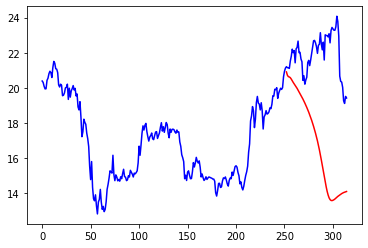

,Prediction
Date,
2021-01-04,20.900000
2021-01-05,20.709999
2021-01-06,20.629999
2021-01-07,20.610001
2021-01-08,20.570000
...,...
2021-03-25,13.980000
2021-03-26,14.010000
2021-03-29,14.030000


In [184]:
model_LSTM(data1, 10, 200, model_type ='bi')

Next 63 values:  [21.28, 21.53, 21.8, 22.07, 22.35, 22.65, 22.96, 23.26, 23.56, 23.86, 24.17, 24.48, 24.8, 25.13, 25.47, 25.83, 26.2, 26.61, 27.05, 27.52, 28.02, 28.57, 29.14, 29.75, 30.4, 31.08, 31.8, 32.56, 33.35, 34.17, 35.03, 35.93, 36.86, 37.84, 38.86, 39.94, 41.09, 42.32, 43.64, 45.06, 46.58, 48.18, 49.8, 51.39, 52.84, 54.09, 55.05, 55.55, 55.23, 53.48, 49.71, 44.3, 39.09, 34.61, 30.36, 26.84, 23.32, 17.72, 10.82, 12.01, 13.43, 16.98, 19.17]
Test Score: 15.18 RMSE


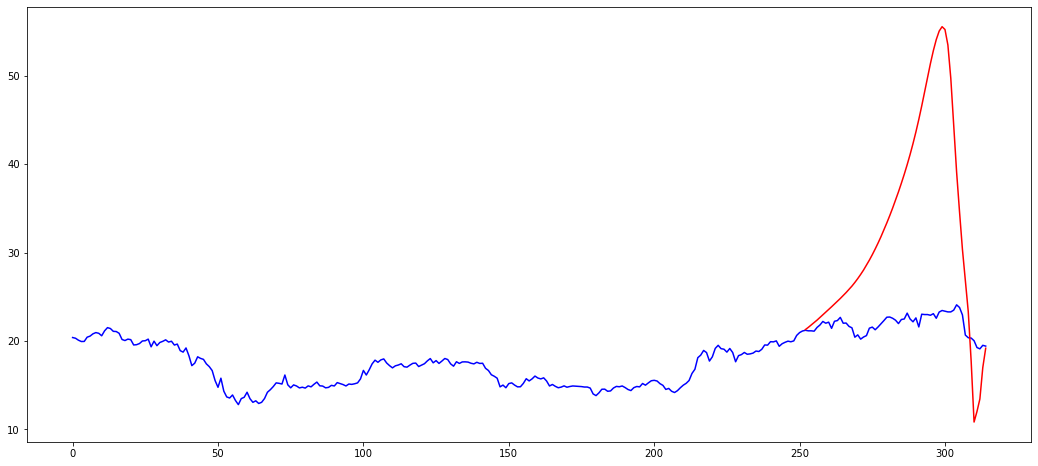

,Prediction
Date,
2021-01-04,21.280001
2021-01-05,21.530001
2021-01-06,21.799999
2021-01-07,22.070000
2021-01-08,22.350000
...,...
2021-03-25,10.820000
2021-03-26,12.010000
2021-03-29,13.430000


In [166]:
model_LSTM(data1, 30, 200)

Next 63 values:  [20.93, 21.01, 21.03, 21.11, 21.13, 21.24, 21.31, 21.39, 21.46, 21.55, 21.62, 21.7, 21.77, 21.85, 21.92, 22.0, 22.07, 22.15, 22.22, 22.3, 22.37, 22.44, 22.49, 22.54, 22.59, 22.63, 22.66, 22.7, 22.74, 22.78, 22.82, 22.86, 22.9, 22.94, 22.97, 23.0, 23.02, 23.04, 23.06, 23.08, 23.09, 23.1, 23.11, 23.11, 23.11, 23.11, 23.11, 23.11, 23.11, 23.11, 23.11, 23.1, 23.1, 23.1, 23.09, 23.08, 23.07, 23.06, 23.05, 23.04, 23.02, 23.01, 23.0]
Test Score: 1.37 RMSE


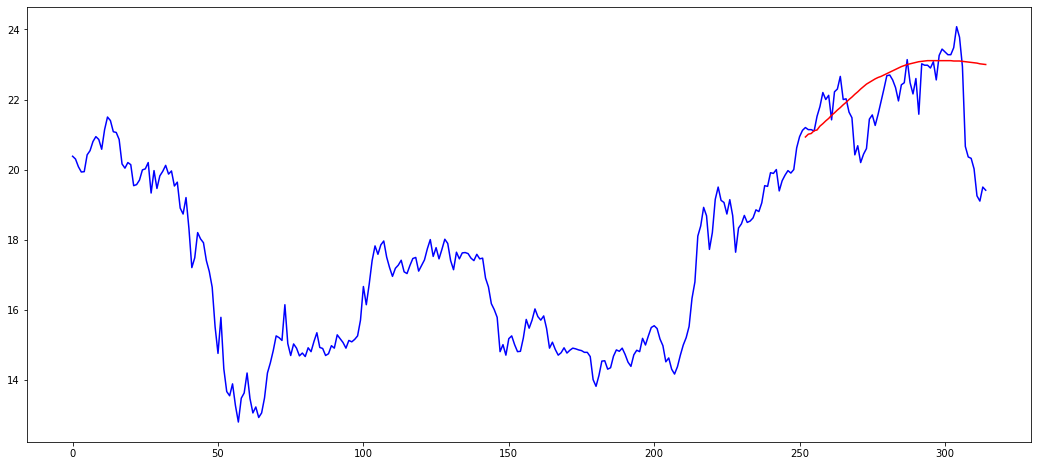

,Prediction
Date,
2021-01-04,20.930000
2021-01-05,21.010000
2021-01-06,21.030001
2021-01-07,21.110001
2021-01-08,21.129999
...,...
2021-03-25,23.049999
2021-03-26,23.040001
2021-03-29,23.020000


In [176]:
model_LSTM(data1, 30, 200, model_type ='seq')

Next 63 values:  [21.49, 21.9, 22.34, 22.79, 23.26, 23.84, 24.36, 24.9, 25.39, 25.84, 26.25, 26.59, 26.81, 26.89, 26.81, 26.39, 25.84, 25.07, 24.22, 23.15, 22.18, 21.32, 20.58, 19.87, 19.27, 18.82, 18.41, 18.07, 17.84, 17.68, 17.54, 17.37, 17.1, 16.67, 16.02, 15.15, 14.16, 13.21, 12.39, 11.87, 11.79, 12.09, 12.52, 12.89, 13.17, 13.38, 13.56, 13.75, 14.01, 14.3, 14.57, 14.8, 14.97, 15.08, 15.13, 15.13, 15.09, 15.03, 14.97, 14.93, 14.93, 14.99, 15.09]
Test Score: 6.23 RMSE


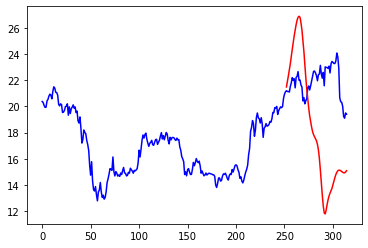

,Prediction
Date,
2021-01-04,21.490000
2021-01-05,21.900000
2021-01-06,22.340000
2021-01-07,22.790001
2021-01-08,23.260000
...,...
2021-03-25,14.970000
2021-03-26,14.930000
2021-03-29,14.930000


In [185]:
model_LSTM(data1, 30, 200, model_type ='bi')

Next 63 values:  [21.1, 20.97, 20.8, 20.56, 20.24, 19.88, 19.5, 19.14, 18.79, 18.49, 18.26, 18.13, 18.09, 18.08, 17.96, 17.61, 17.0, 16.23, 15.37, 14.44, 13.49, 12.56, 11.78, 11.23, 11.01, 11.17, 11.71, 12.55, 13.39, 13.68, 13.28, 12.66, 12.2, 12.04, 12.16, 12.55, 13.18, 14.0, 14.8, 15.3, 15.35, 15.13, 14.9, 14.78, 14.76, 14.82, 14.9, 14.96, 14.97, 14.94, 14.87, 14.8, 14.74, 14.69, 14.67, 14.69, 14.75, 14.85, 14.99, 15.17, 15.37, 15.58, 15.79]
Test Score: 7.15 RMSE


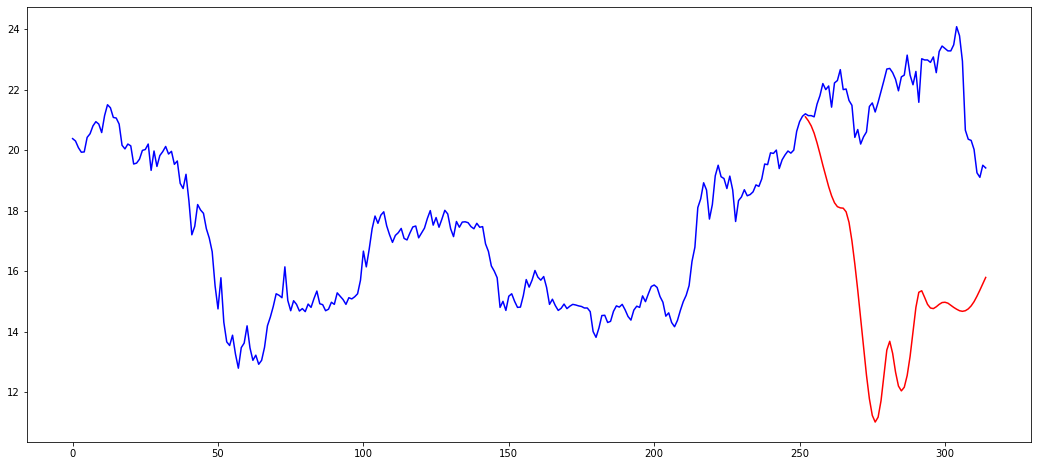

,Prediction
Date,
2021-01-04,21.100000
2021-01-05,20.969999
2021-01-06,20.799999
2021-01-07,20.559999
2021-01-08,20.240000
...,...
2021-03-25,14.990000
2021-03-26,15.170000
2021-03-29,15.370000


In [169]:
model_LSTM(data1, 60, 200)

Next 63 values:  [19.69, -6.14, -20.71, -13.15, 23.49, 46.09, -0.88, -10.99, 1.24, 1.69, 11.81, 4.66, 10.47, 3.13, 27.3, 27.15, 26.21, 18.78, 27.83, 22.68, 24.43, 27.34, 28.74, 28.57, 20.11, 5.42, 34.76, 54.36, 23.05, 76.38, 73.6, 66.84, 77.63, 18.96, 36.71, 37.25, 5.16, 5.28, 27.75, 25.97, 34.7, 24.74, 28.25, 39.18, 43.62, 52.55, 60.85, 68.12, 92.76, 78.8, 153.09, 175.18, 6.78, -2.51, 98.11, 26.25, -45.06, 71.08, 87.86, -34.56, 10.78, -53.89, 3.33]
Test Score: 39.97 RMSE


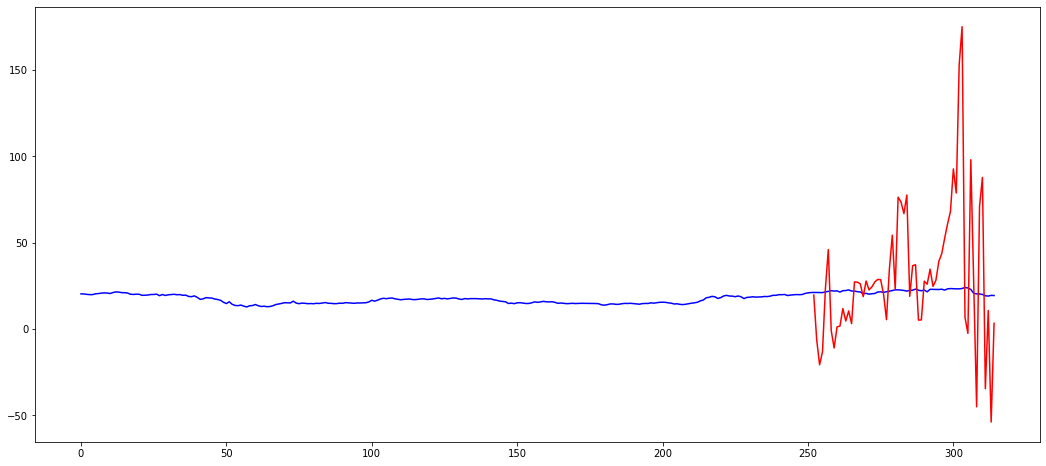

,Prediction
Date,
2021-01-04,19.690001
2021-01-05,-6.140000
2021-01-06,-20.709999
2021-01-07,-13.150000
2021-01-08,23.490000
...,...
2021-03-25,87.860001
2021-03-26,-34.560001
2021-03-29,10.780000


In [177]:
model_LSTM(data1, 60, 200, model_type ='seq')

Next 63 values:  [20.73, 20.64, 20.23, 19.33, 18.98, 17.28, 15.72, 14.46, 13.62, 13.52, 13.37, 14.25, 13.87, 14.26, 14.41, 15.44, 15.32, 15.42, 15.57, 15.31, 15.35, 15.15, 15.42, 15.19, 15.48, 15.48, 15.66, 15.66, 15.86, 15.73, 15.56, 15.43, 15.34, 15.13, 15.1, 15.21, 15.36, 15.27, 15.17, 15.42, 15.68, 14.91, 14.3, 14.86, 14.75, 14.58, 14.46, 14.54, 14.46, 14.43, 14.47, 14.61, 14.72, 14.89, 15.2, 15.53, 15.93, 16.36, 16.78, 17.15, 17.44, 17.6, 17.63]
Test Score: 6.68 RMSE


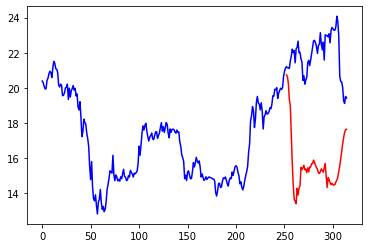

,Prediction
Date,
2021-01-04,20.730000
2021-01-05,20.639999
2021-01-06,20.230000
2021-01-07,19.330000
2021-01-08,18.980000
...,...
2021-03-25,16.780001
2021-03-26,17.150000
2021-03-29,17.440001


In [186]:
model_LSTM(data1, 60, 200, model_type ='bi')

Next 63 values:  [6.32, 6.45, 5.33, 5.12, 4.84, 4.61, 4.37, 4.14, 3.91, 3.68, 3.45, 3.23, 3.02, 2.82, 2.64, 2.46, 2.3, 2.16, 2.02, 1.9, 1.79, 1.69, 1.6, 1.52, 1.44, 1.38, 1.32, 1.26, 1.22, 1.17, 1.14, 1.11, 1.08, 1.06, 1.04, 1.02, 1.0, 0.99, 0.98, 0.97, 0.96, 0.96, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
Test Score: 20.06 RMSE


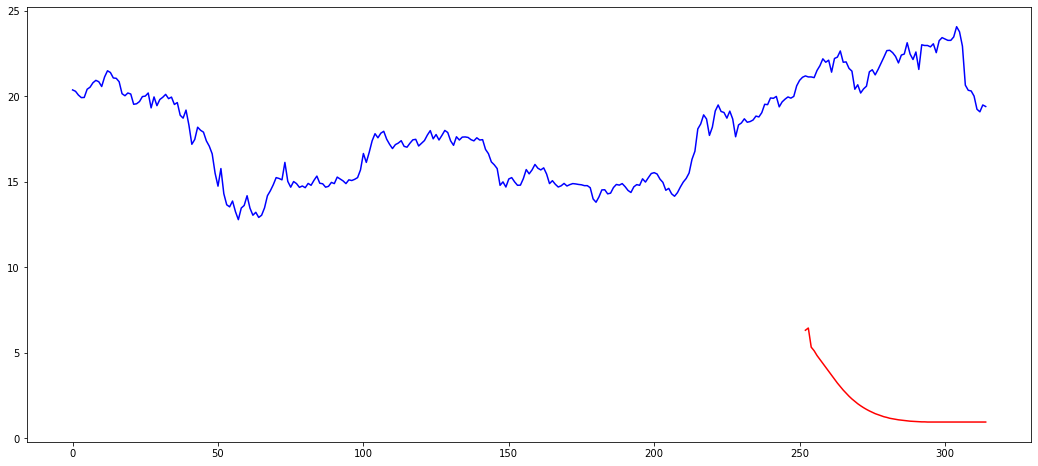

,Prediction
Date,
2021-01-04,6.32
2021-01-05,6.45
2021-01-06,5.33
2021-01-07,5.12
2021-01-08,4.84
...,...
2021-03-25,0.95
2021-03-26,0.95
2021-03-29,0.95


In [170]:
model_LSTM(data1, 90, 200)

Next 63 values:  [10.46, 10.08, 9.7, 9.41, 9.16, 8.92, 8.66, 8.4, 8.14, 7.88, 7.62, 7.35, 7.07, 6.78, 6.48, 6.16, 5.83, 5.48, 5.09, 4.68, 4.27, 3.85, 3.44, 3.0, 2.57, 2.17, 1.8, 1.46, 1.16, 0.92, 0.73, 0.58, 0.47, 0.38, 0.31, 0.26, 0.23, 0.2, 0.18, 0.17, 0.16, 0.15, 0.14, 0.14, 0.14, 0.14, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]
Test Score: 19.35 RMSE


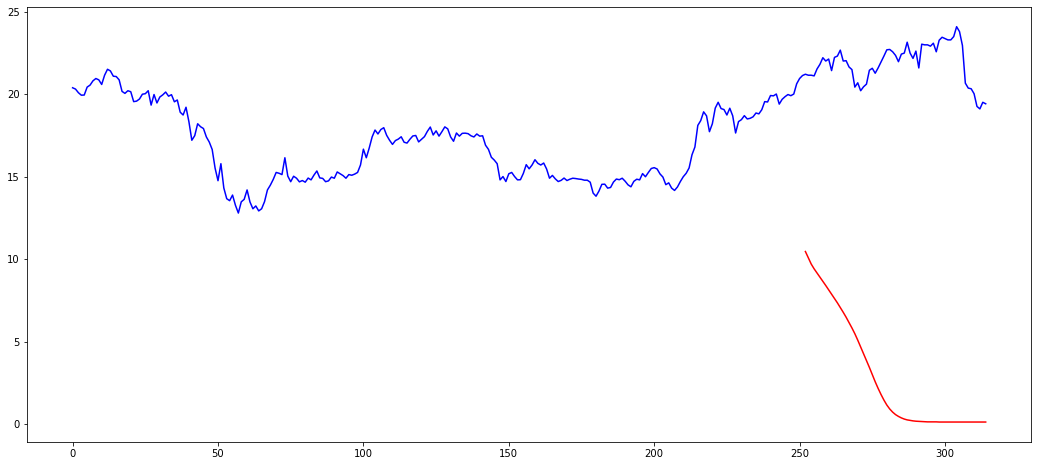

,Prediction
Date,
2021-01-04,10.46
2021-01-05,10.08
2021-01-06,9.70
2021-01-07,9.41
2021-01-08,9.16
...,...
2021-03-25,0.13
2021-03-26,0.13
2021-03-29,0.13


In [178]:
model_LSTM(data1, 90, 200, model_type ='seq')

Next 63 values:  [20.74, 20.91, 20.96, 21.17, 21.21, 21.37, 21.41, 21.51, 21.56, 21.64, 21.7, 21.76, 21.82, 21.87, 21.92, 21.96, 21.96, 21.93, 21.85, 21.66, 21.25, 20.3, 19.01, 17.76, 16.73, 15.87, 15.03, 14.06, 12.96, 11.73, 10.43, 9.28, 8.44, 7.52, 6.84, 6.55, 6.44, 6.35, 6.24, 6.13, 6.02, 5.89, 5.78, 5.66, 5.51, 5.36, 5.2, 5.04, 4.86, 4.66, 4.47, 4.25, 4.07, 3.86, 3.67, 3.49, 3.26, 3.06, 2.92, 2.81, 2.68, 2.57, 2.44]
Test Score: 12.59 RMSE


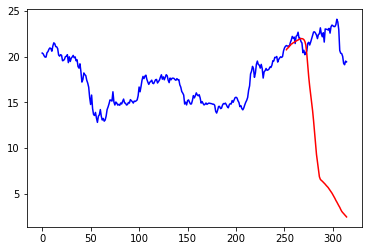

,Prediction
Date,
2021-01-04,20.740000
2021-01-05,20.910000
2021-01-06,20.959999
2021-01-07,21.170000
2021-01-08,21.209999
...,...
2021-03-25,2.920000
2021-03-26,2.810000
2021-03-29,2.680000


In [188]:
model_LSTM(data1, 90, 200, model_type ='bi')

### Weekly basis

In [ ]:
model_LSTM(data1W, 2, 100)

In [ ]:
model_LSTM(data1W, 10, 100)

### Monthly basis

In [ ]:
model_LSTM(data1M, 1, 100)

In [ ]:
model_LSTM(data1M, 3, 100)

Multi-Step LSTM Models?


Vector Output Model?
Encoder-Decoder Model?

# CNN LSTM

In [319]:
def model_CNN_LSTM(dataset, look_back=1, n_steps=2, epochs = 5):
    
    train = pre_LSTM(dataset[dataset.index < '2021-01-01'])
    testY = pre_LSTM(dataset[dataset.index >= '2021-01-01'])
    
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)

    
    n_seq = look_back//n_steps
    # reshape input to be [samples, subsequences, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], n_seq, n_steps, 1))
    
    # create and fit the LSTM network

    tf.random.set_seed(41)

    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    model.fit(trainX, trainY, epochs=epochs, verbose=0)
    

    # make predictions

    # Prepare input data
    inputs = trainX[-1:]
    a = np.append(inputs[:,0,1:,:], [inputs[:,1,0,:]], axis=1)
    b = np.append([inputs[:,1,1,:]], [[[trainY[-1]]]], axis=1)
    inputs = np.append([a], [b], axis=1)

    # Predict next values
    forecasts = []
    for i in range(len(testY)):
        # Forecast next value
        forecast = model.predict(inputs, verbose = 0)
        forecast = forecast[-1][-1].round(2)
        forecasts.append(forecast)
        
        a = np.append(inputs[:,0,1:,:], [inputs[:,1,0,:]], axis=1)
        b = np.append([inputs[:,1,1,:]], [[[forecast]]], axis=1)
        # Update input sequence
        inputs = np.append([a], [b], axis=1)
    
    # Print forecasts
    print(f"Next {len(forecasts)} values: ", forecasts)   
    testScore = np.sqrt(mean_squared_error(testY, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))

    
    #make dataframe for results
    df_forecast = pd.DataFrame(forecasts,columns=['Prediction'])
    df_forecast.index = dataset[dataset.index >= '2021-01-01'].index
    
    forecasts = np.array(forecasts)
    forecasts = forecasts.reshape(-1, 1)
    
    dataset = pre_LSTM(dataset)
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[-len(testY):, :] = forecasts
    
    # plot baseline and predictions
    plt.plot(dataset, color = 'b')
    plt.plot(testPredictPlot, color = 'r')
    plt.show()
    
    return df_forecast


In [320]:
model_CNN_LSTM(data1, 10, 100)

ValueError: cannot reshape array of size 2420 into shape (242,0,100,1)

Next 63 values:  [2.23, 2.2, 1.35, 1.34, 0.16, 0.16, 0.07, 0.07, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
Test Score: 21.79 RMSE


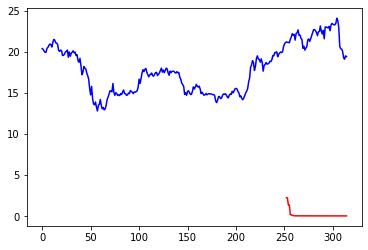

,Prediction
Date,
2021-01-04,2.23
2021-01-05,2.20
2021-01-06,1.35
2021-01-07,1.34
2021-01-08,0.16
...,...
2021-03-25,0.01
2021-03-26,0.01
2021-03-29,0.01


In [315]:
model_CNN_LSTM(data1, 30, 100)

## Auto-ARIMA model

In [27]:
from pmdarima import auto_arima

In [29]:
def auto_ARIMA(dataframe):
    # split into train and test sets
    train = dataframe[dataframe.index < '2021-01-01']
    valid = dataframe[dataframe.index >= '2021-01-01']
    model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(valid))
    forecast = pd.DataFrame(forecast,columns=['Prediction'])
    forecast.index = valid.index
    #plot the predictions for validation set
    plt.plot(train, label='Train', color = 'b')
    plt.plot(valid, label='Valid', color = 'g')
    plt.plot(forecast, label='Prediction', color = 'r')
    plt.show()
    
    testScore = np.sqrt(mean_squared_error(valid, forecast))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=259.857, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=254.949, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=256.283, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=256.238, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=252.963, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=257.994, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.638 seconds


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


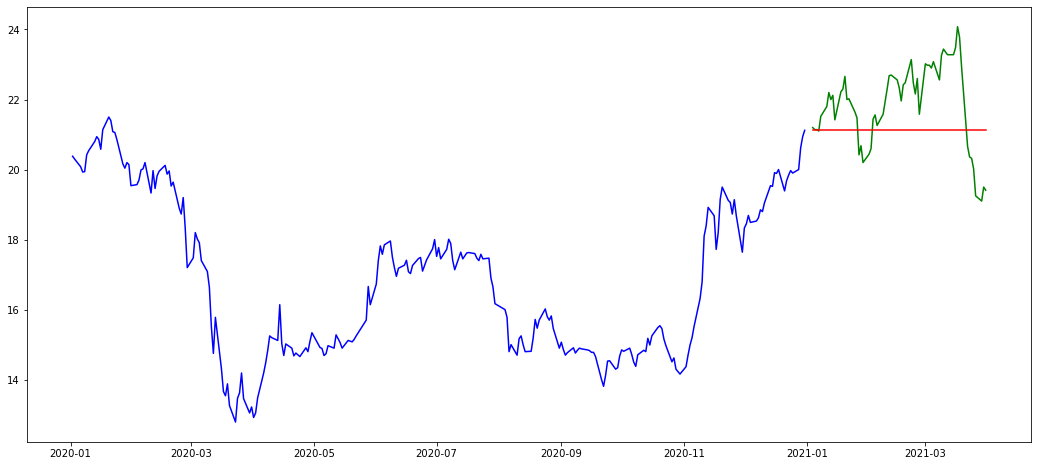

Test Score: 1.39 RMSE


,Prediction
Date,
2021-01-04,21.12
2021-01-05,21.12
2021-01-06,21.12
2021-01-07,21.12
2021-01-08,21.12
...,...
2021-03-25,21.12
2021-03-26,21.12
2021-03-29,21.12


In [30]:
auto_ARIMA(data1['Price'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=234.153, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=149.581, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=183.706, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=443.881, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=148.025, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=149.501, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=147.379, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=149.325, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=168.797, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=152.938, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.682 seconds


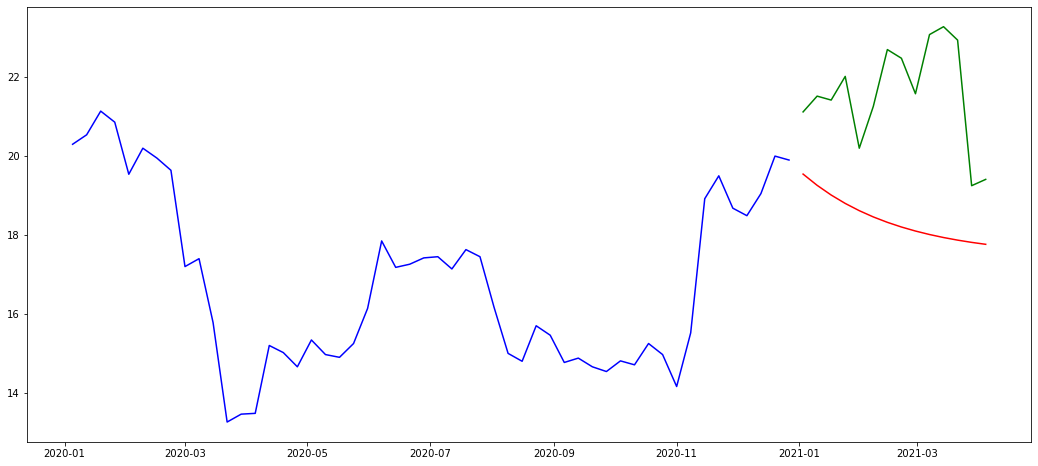

Test Score: 3.47 RMSE


,Prediction
Date,
2021-01-03,19.544318
2021-01-10,19.259390
2021-01-17,19.013272
2021-01-24,18.800678
2021-01-31,18.617043
2021-02-07,18.458420
2021-02-14,18.321404
2021-02-21,18.203052
2021-02-28,18.100820


In [31]:
auto_ARIMA(data1W['Price'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=59.020, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.034, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=57.656, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=55.479, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=103.560, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=57.476, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.433 seconds


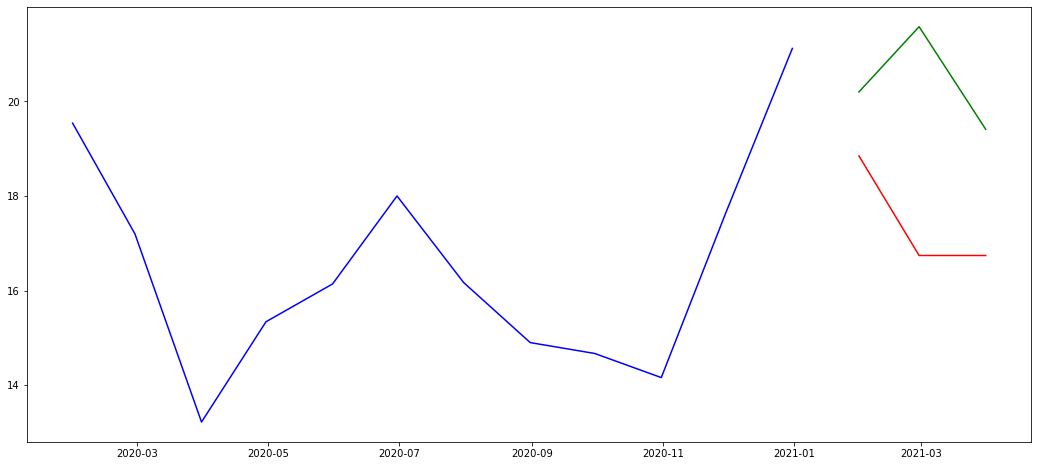

Test Score: 3.28 RMSE


,Prediction
Date,
2021-01-31,18.848042
2021-02-28,16.741699
2021-03-31,16.741699


In [32]:
auto_ARIMA(data1M['Price'])

## Prophet model

In [124]:
def model_prophet(df, frequency):
    
    # Prepare the data for Prophet
    df = df.rename(columns={'Price': 'y'})
    df = df.reset_index().rename(columns={'Date': 'ds'})
    
    # split into train and test sets
    train = df[df['ds'] < '2021-01-01']
    test = df[df['ds'] >= '2021-01-01']
    

    # Create a Prophet model and fit it to the data
    model = Prophet()
    model.fit(train)

    # Make predictions for the next 365 days
    future = model.make_future_dataframe(periods=len(test), freq=frequency)
    forecast = model.predict(future)

    # Plot the forecast
#     model.plot(forecast)
    #plot the predictions for validation set
    plt.plot(df['y'])
    plt.plot(forecast[forecast['ds'] >= '2021-01-01']['yhat'])
    plt.show()
    
    
    testScore = np.sqrt(mean_squared_error(test['y'], forecast[forecast['ds'] >= '2021-01-01']['yhat']))
    print('Test Score: %.2f RMSE' % (testScore))
    
    forecast = forecast[forecast['ds'] >= '2021-01-01']
    forecast['ds'] = test['ds']
    #results = results['yhat']
    forecast = forecast.set_index('ds')
    forecast.index.name = None
    forecast = forecast[['yhat']]
    forecast = forecast.rename(columns={"yhat": "Prediction"})
    

    
    return forecast

10:55:24 - cmdstanpy - INFO - Chain [1] start processing
10:55:24 - cmdstanpy - INFO - Chain [1] done processing


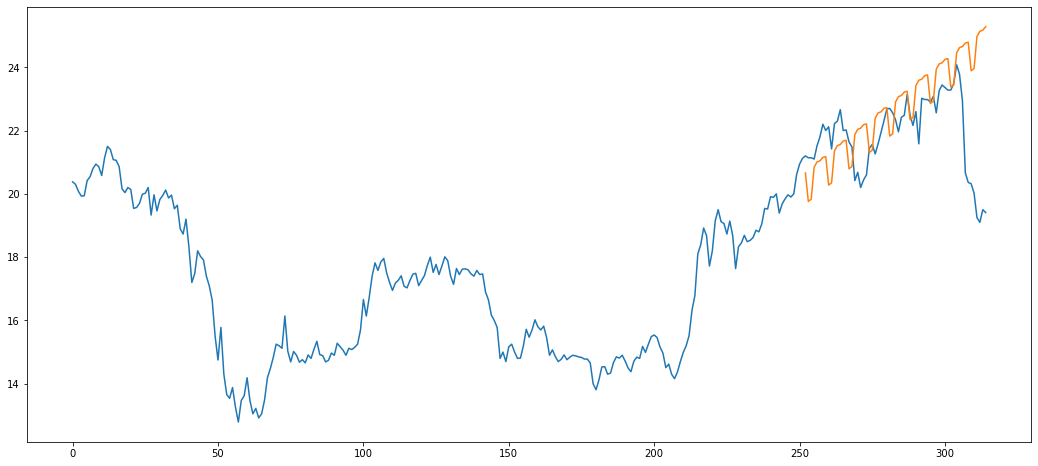

Test Score: 1.99 RMSE


In [125]:
forecast = model_prophet(data1, 'D')

16:01:28 - cmdstanpy - INFO - Chain [1] start processing
16:01:28 - cmdstanpy - INFO - Chain [1] done processing


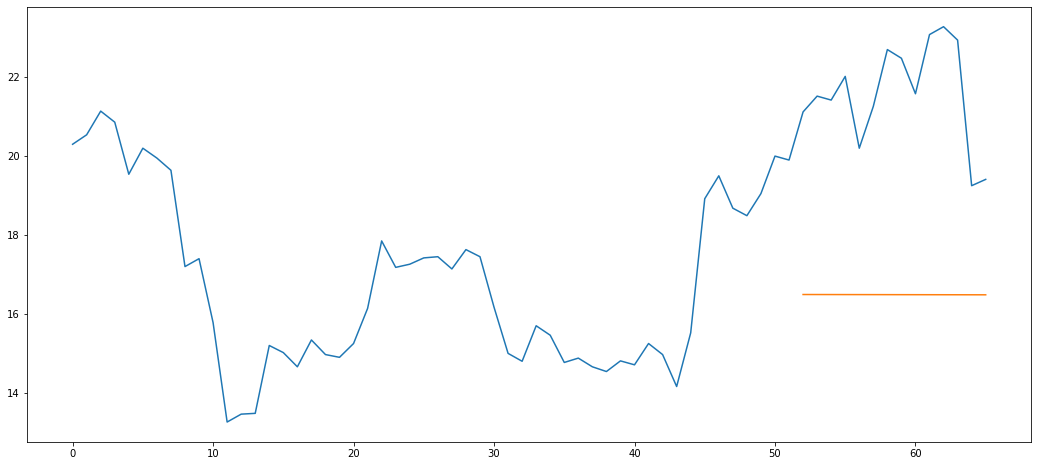

Test Score: 5.25 RMSE
            Prediction
2021-01-03   16.491988
2021-01-10   16.491413
2021-01-17   16.490838
2021-01-24   16.490264
2021-01-31   16.489689
2021-02-07   16.489115
2021-02-14   16.488540
2021-02-21   16.487966
2021-02-28   16.487391
2021-03-07   16.486817
2021-03-14   16.486242
2021-03-21   16.485668
2021-03-28   16.485093
2021-04-04   16.484519


,Prediction
2021-01-03,16.491988
2021-01-10,16.491413
2021-01-17,16.490838
2021-01-24,16.490264
2021-01-31,16.489689
2021-02-07,16.489115
2021-02-14,16.488540
2021-02-21,16.487966
2021-02-28,16.487391
2021-03-07,16.486817


In [94]:
model_prophet(data1W, 'W')

16:01:41 - cmdstanpy - INFO - Chain [1] start processing
16:01:41 - cmdstanpy - INFO - Chain [1] done processing


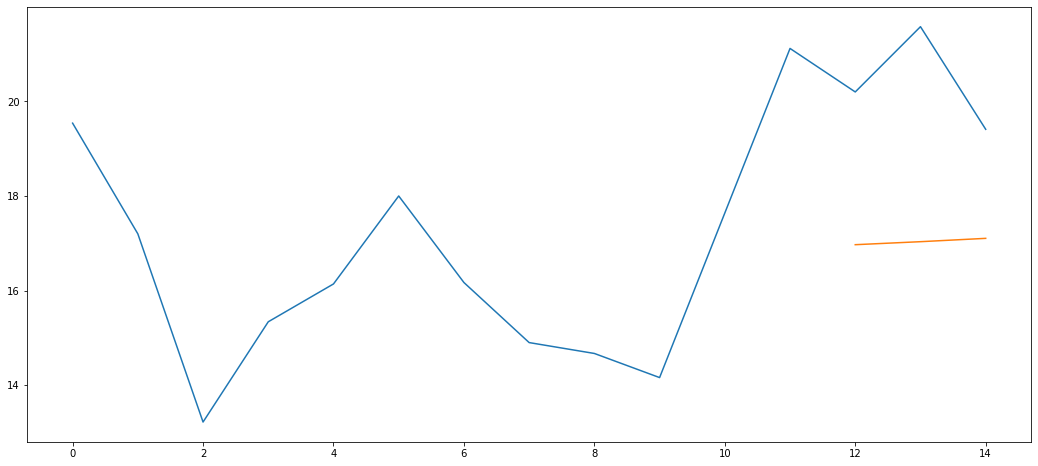

Test Score: 3.48 RMSE
            Prediction
2021-01-31   16.969960
2021-02-28   17.033633
2021-03-31   17.104127


,Prediction
2021-01-31,16.969960
2021-02-28,17.033633
2021-03-31,17.104127


In [95]:
model_prophet(data1M, 'M')

# 5 - Recommendations

In [105]:
def BB(df):
    # Assuming your DataFrame is named 'df' and 'Prediction' is the column of interest
    window = 20  # Bollinger Bands window size
    std_dev = 2  # Standard deviation for the bands

    # Calculate the rolling mean and standard deviation
    rolling_mean = df['Prediction'].rolling(window=window).mean()
    rolling_std = df['Prediction'].rolling(window=window).std()

    # Calculate the upper and lower bands
    upper_band = rolling_mean + std_dev * rolling_std
    lower_band = rolling_mean - std_dev * rolling_std
    
    df['Upper'] = upper_band
    df['Lower'] = lower_band

    # Plot the Bollinger Bands
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['actual'], label='Price')
    plt.plot(df.index, rolling_mean, label='Rolling Mean')
    plt.plot(df.index, upper_band, label='Upper Band')
    plt.plot(df.index, lower_band, label='Lower Band')
    plt.fill_between(df.index, lower_band, upper_band, alpha=0.2)  # Fill area between the bands
    plt.legend()
    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Prediction')
    plt.axvline(x='2021-01-01', color='black', linestyle='dashed')
    plt.show()
    
    return df

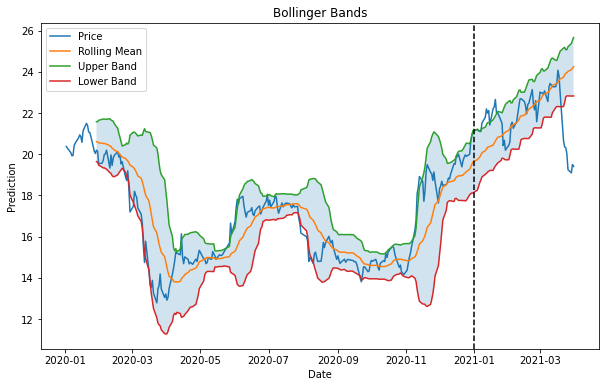

In [126]:
a = data1[data1.index < '2021-01-01']['Price']
b = forecast['Prediction']
c = pd.concat([a,b])
predictions = c.to_frame().rename(columns={0: 'Prediction'})
predictions['actual'] = data1['Price']
newdf = BB(predictions)

In [127]:
newdf = newdf[newdf.index >= '2021-01-01']
newdf['higher'] = newdf['actual'] > newdf['Upper']
higher = newdf[newdf['higher']]
newdf['lower'] = newdf['actual'] < newdf['Lower']
lower = newdf[newdf['lower']]

<ipython-input-127-554a5a422895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['higher'] = newdf['actual'] > newdf['Upper']
<ipython-input-127-554a5a422895>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['lower'] = newdf['actual'] < newdf['Lower']


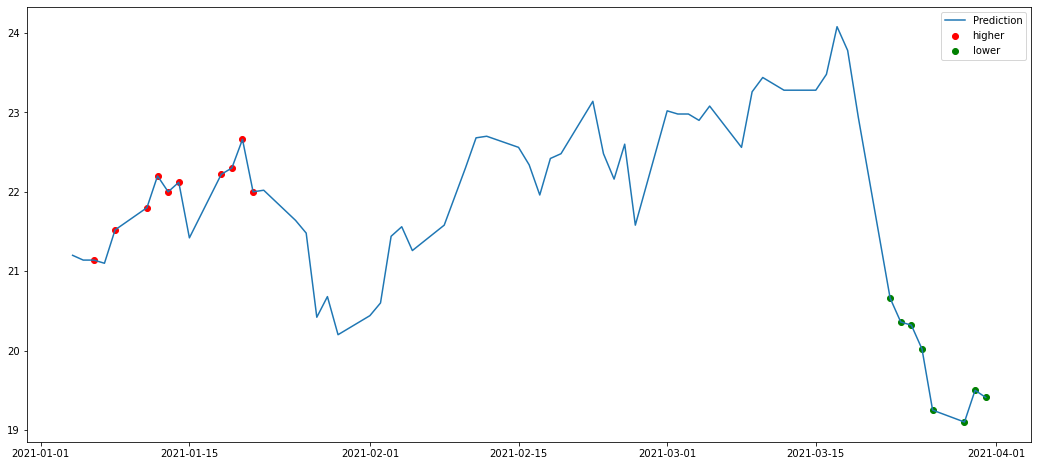

In [128]:
plt.plot(newdf.index, newdf['actual'], label='Prediction')
plt.scatter(higher.index, higher['actual'], label='higher', color = 'r')
plt.scatter(lower.index, lower['actual'], label='lower', color = 'g')
plt.legend()

In [131]:
newdf

,Prediction,actual,Upper,Lower,higher,lower
2021-01-04,20.660414,21.20,21.215921,18.267121,False,False
2021-01-05,19.759342,21.14,21.162770,18.443206,False,False
2021-01-06,19.833086,21.14,21.104241,18.623044,True,False
2021-01-07,20.840969,21.10,21.180621,18.745760,False,False
2021-01-08,21.008137,21.52,21.246561,18.900634,True,False
...,...,...,...,...,...,...
2021-03-25,23.962768,20.02,25.079432,22.836241,False,True
2021-03-26,24.970651,19.25,25.220741,22.833079,False,True
2021-03-29,25.137818,19.10,25.378024,22.827234,False,True
2021-03-30,25.172063,19.50,25.522497,22.826616,False,True


In [132]:
# def rec(df):
#     high = 0
#     low = 0
#     h = [0]
#     l = [0]
#     for index,row in df.iterrows():
#         if row['higher']:
#             high = index  
#             if low != 0 and low != l[-1]:
#                 l.append(low)
#         elif row['lower']:
#             low = index
#             if high!= 0 and high != h[-1]:
#                 h.append(high)
    
#     if high > h[-1]:
#         h.append(high)
#     if low > l[-1]:
#         l.append(low)
#     h = h[1:]
#     l = l[1:]
#     higher = df[df['higher']]
#     lower = df[df['lower']]
#     plt.plot(df.index, df['Prediction'], label='Prediction')
#     plt.scatter(higher.index, higher['Prediction'], label='higher', color = 'r')
#     plt.scatter(lower.index, lower['Prediction'], label='lower', color = 'g')
#     for i in h:
#         plt.axvline(x=i, color='r', linestyle='dashed')
#     for i in l:
#         plt.axvline(x=i, color='g', linestyle='dashed')
#     plt.legend()

#     return h,l

In [134]:
# h, l = rec(newdf)

In [119]:
def best_invest(df):
    actions = pd.DataFrame({'Timestamp': h+l, 'Value': ['S']*len(h) + ['B']*len(l)})
    actions.set_index('Timestamp', inplace=True)
    actions = actions.sort_index()
    
    merged_df = pd.merge(actions, df['Prediction'], left_index=True, right_index=True, how='inner')
    merged_df = merged_df.rename(columns = {'Prediction': 'Price'})
    
    combos = []
    for num in range(100):
        shares = 10
        money = 200
        l = [num]
        for index, row in merged_df.iterrows():
            if row['Value'] == 'B':
                num_shares = random.randint(0, round(money/row['Price']))
                shares += num_shares
                money -= num_shares*row['Price']
                l.append(num_shares)
            elif row['Value'] == 'S':
                num_shares = random.randint(0, shares)
                shares -= num_shares
                money += num_shares*row['Price']
                l.append(-num_shares)
        l.append(money)
        combos.append(l)   
    name_columns = ['index'] + list(range(len(combos[0])-2)) + ['total']
    df_combos = pd.DataFrame(combos, columns=name_columns)
    df_combos.set_index('index', inplace=True)
    print(max(df_combos['total']))
    
    strategy = df_combos[df_combos['total'] == max(df_combos['total'])]
    actions = actions.assign(strategy=strategy.iloc[0][:-1].values)
    return actions

actions = best_invest(newdf)    
print(actions)

NameError: name 'h' is not defined

In [ ]:
def test_invest(actions, data):
    shares = 10
    money = 200
    for index, row in actions.iterrows():
        if row['Value'] == 'B':
            print('\nBuy')
            num_shares = abs(row['strategy'])
            print('num', num_shares)
            shares += num_shares
            print('shares now', shares)
            print('price', data.loc[index]['Price'])
            cost = num_shares*data.loc[index]['Price']
            print('cost', cost)
            money -= cost
            print('total', money)
        elif row['Value'] == 'S':
            print('\nSell')
            num_shares = abs(row['strategy'])
            print('num', num_shares)
            shares -= num_shares
            print('shares now', shares)
            print('price', data.loc[index]['Price'])
            cost = num_shares*data.loc[index]['Price']
            print('cost', cost)
            money += cost
            print('total', money)
    print(shares)
    print(money)

In [ ]:
test_invest(actions, data1)